In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maha9876
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


100%|██████████| 920M/920M [00:07<00:00, 126MB/s]


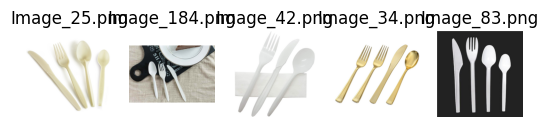

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the main images folder
image_folder = '/content/recyclable-and-household-waste-classification/images/images'

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))

# Display a few sample images
for i, image_path in enumerate(image_paths[:5]):  # Show the first 5 images
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))

plt.show()



In [5]:
import os
import shutil
import random

# Define paths
dataset_dir = '/content/recyclable-and-household-waste-classification/images/images'
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'

# Ensure train and val directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Process each class in the dataset directory
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        # Create class folders in train and val directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/val sets
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy images to train and val directories
        for image_path in train_images:
            dest_path = os.path.join(train_dir, class_name, os.path.basename(image_path))
            shutil.copyfile(image_path, dest_path)

        for image_path in val_images:
            dest_path = os.path.join(val_dir, class_name, os.path.basename(image_path))
            shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and val folders!")


Dataset successfully split into train and val folders!


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Set up paths for train and val data
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (e.g., ResNet18)
model = models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 1.8430
Validation Accuracy: 72.80%
Epoch [2/10], Loss: 0.8137
Validation Accuracy: 79.24%
Epoch [3/10], Loss: 0.5604
Validation Accuracy: 80.75%
Epoch [4/10], Loss: 0.4017
Validation Accuracy: 81.46%
Epoch [5/10], Loss: 0.2976
Validation Accuracy: 83.46%
Epoch [6/10], Loss: 0.2392
Validation Accuracy: 83.38%
Epoch [7/10], Loss: 0.1758
Validation Accuracy: 82.75%
Epoch [8/10], Loss: 0.1503
Validation Accuracy: 83.12%
Epoch [9/10], Loss: 0.1266
Validation Accuracy: 83.60%
Epoch [10/10], Loss: 0.1103
Validation Accuracy: 83.64%


In [15]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Define the path to the main images folder
image_folder = '/content/recyclable-and-household-waste-classification/images/images'
output_dir = '/content/split_dataset'

# Define output paths for train and val sets
train_image_dir = os.path.join(output_dir, 'train/images')
val_image_dir = os.path.join(output_dir, 'val/images')

# Create directories for train and validation images and labels
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)

# Traverse and collect image paths, assuming labels have the same file names
image_paths = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # adjust for image formats in dataset
            image_paths.append(os.path.join(root, file))

# Split data into train and validation sets
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Helper function to copy images to their respective directories
def copy_files(file_paths, destination_folder):
    for file_path in file_paths:
        # Copy the image
        shutil.copy(file_path, destination_folder)

# Copy images to train and validation folders
copy_files(train_paths, train_image_dir)
copy_files(val_paths, val_image_dir)

print(f"Train and validation sets created at '{output_dir}' with {len(train_paths)} train images and {len(val_paths)} val images.")


Train and validation sets created at '/content/split_dataset' with 12000 train images and 3000 val images.


In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Set up paths
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'


In [17]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [19]:
import os
import shutil
import pandas as pd

# Example paths - update these paths based on your setup
dataset_dir = '/content/recyclable-and-household-waste-classification/images/images'
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'
labels_csv_path = '/content/recyclable-and-household-waste-classification/labels.csv'  # Path to labels CSV

# Read the labels CSV
# Assuming the CSV has columns: ['filename', 'label']
labels_df = pd.read_csv(labels_csv_path)

# Create class folders
for label in labels_df['label'].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# Split into train and val and move files
train_ratio = 0.8  # 80% train, 20% val
for label in labels_df['label'].unique():
    label_images = labels_df[labels_df['label'] == label]['filename']
    split_idx = int(len(label_images) * train_ratio)
    train_images = label_images[:split_idx]
    val_images = label_images[split_idx:]

    # Move images to train and val directories
    for image in train_images:
        shutil.move(os.path.join(dataset_dir, image), os.path.join(train_dir, label, image))
    for image in val_images:
        shutil.move(os.path.join(dataset_dir, image), os.path.join(val_dir, label, image))


FileNotFoundError: [Errno 2] No such file or directory: '/content/recyclable-and-household-waste-classification/labels.csv'

In [18]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check class labels
class_names = train_dataset.classes
print("Class labels:", class_names)


FileNotFoundError: Couldn't find any class folder in /content/split_dataset/train/images.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/kaggle/input/recyclable-and-household-waste-classification/images/images/"

In [ ]:
directory = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1"

In [ ]:
# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='training',
    seed=42
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='validation',
    seed=42
)

Found 15000 files belonging to 1 classes.
Using 12000 files for training.
Found 15000 files belonging to 1 classes.
Using 3000 files for validation.


In [ ]:
# Verify the dataset structure
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")

Class names: ['images']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 1)
Labels: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
